<a href="https://colab.research.google.com/github/AmlanAlok/instacart-2017-project/blob/PCA-XGBoost-02/Instacart_2017_PCA_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For data manipulation
import pandas as pd    
import xgboost
from sklearn.model_selection import train_test_split
import time

import numpy as np # algebra & calculus
from google.colab import drive
drive.mount('/content/drive/')

%cd 'drive/MyDrive/9-Projects/1-ML-Instacart'

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Garbage Collector to free up memory
import gc                         
gc.enable()

cluster_count = 3
c1, c2 = 2, 3

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/9-Projects/1-ML-Instacart


In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
products = pd.read_csv("products.csv")
# orders = pd.read_csv("orders_50.csv")
# order_products_prior = pd.read_csv("op_prior_50.csv")
# order_products_train = pd.read_csv("op_train_50.csv")
orders = pd.read_csv("orders_100.csv")
order_products_prior = pd.read_csv("op_prior_100.csv")
order_products_train = pd.read_csv("op_train_100.csv")
# orders = pd.read_csv("orders.csv")
# order_products_prior = pd.read_csv("order_products__prior.csv")
# order_products_train = pd.read_csv("order_products__train.csv")

print("aisles: ",aisles.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisles:  (134, 2)
departments:  (21, 2)
orders:  (1665732, 7)
products:  (49688, 4)
order_products_prior:  (15806241, 4)
order_products_train:  (672294, 4)


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665732 entries, 0 to 1665731
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                1665732 non-null  int64  
 1   user_id                 1665732 non-null  int64  
 2   eval_set                1665732 non-null  object 
 3   order_number            1665732 non-null  int64  
 4   order_dow               1665732 non-null  int64  
 5   order_hour_of_day       1665732 non-null  int64  
 6   days_since_prior_order  1565733 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 89.0+ MB


In [4]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15806241 entries, 0 to 15806240
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 482.4 MB


In [5]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')


orders['order_dow'] = orders['order_dow'].astype('int8')
orders['order_hour_of_day'] = orders['order_hour_of_day'].astype('int8')
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('float16')
orders['user_id'] = orders['user_id'].astype('int32')
orders['order_id'] = orders['order_id'].astype('int32')
order_products_prior['order_id'] = order_products_prior['order_id'].astype('int32')
order_products_prior['product_id'] = order_products_prior['product_id'].astype('int16')
order_products_prior['add_to_cart_order'] = order_products_prior['add_to_cart_order'].astype('int8')
order_products_prior['reordered'] = order_products_prior['reordered'].astype('int8')

In [6]:
print('orders.shape =', orders.shape)
orders.head()

orders.shape = (1665732, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
order_prior = pd.merge(order_products_prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1993203,431534,196,1,1,1,prior,5,4,15,28.0
1993204,431534,12427,2,1,1,prior,5,4,15,28.0
1993205,431534,10258,3,1,1,prior,5,4,15,28.0
1993206,431534,25133,4,1,1,prior,5,4,15,28.0
1993207,431534,10326,5,0,1,prior,5,4,15,28.0


In [8]:
_mt = pd.merge(order_products_prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
_mt = pd.merge(_mt,departments,on=['department_id','department_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,6,15873,2,0,Dryer Sheets Geranium Scent,75,17,22352,prior,4,1,12,30.0,household,laundry
1,125669,15873,5,0,Dryer Sheets Geranium Scent,75,17,11895,prior,2,3,14,7.0,household,laundry
2,157822,15873,25,0,Dryer Sheets Geranium Scent,75,17,81164,prior,18,3,11,18.0,household,laundry
3,182327,15873,13,0,Dryer Sheets Geranium Scent,75,17,78562,prior,9,4,11,14.0,household,laundry
4,258957,15873,8,0,Dryer Sheets Geranium Scent,75,17,4082,prior,1,6,8,NaN,household,laundry
5,402365,15873,4,0,Dryer Sheets Geranium Scent,75,17,88730,prior,2,3,9,13.0,household,laundry
6,637696,15873,9,0,Dryer Sheets Geranium Scent,75,17,58052,prior,15,3,12,19.0,household,laundry
7,697180,15873,1,1,Dryer Sheets Geranium Scent,75,17,88730,prior,11,6,10,9.0,household,laundry
8,697180,9321,3,0,Clean Day Baby Blossom Laundry Detergent,75,17,88730,prior,11,6,10,9.0,household,laundry
9,698714,15873,11,1,Dryer Sheets Geranium Scent,75,17,88730,prior,7,2,8,4.0,household,laundry


In [9]:
mt['product_name'].value_counts()[0:10]

Banana                    230669
Bag of Organic Bananas    184594
Organic Strawberries      127820
Organic Baby Spinach      118742
Strawberries               69200
Limes                      68597
Organic Raspberries        67327
Organic Whole Milk         66706
Organic Yellow Onion       55826
Organic Garlic             54304
Name: product_name, dtype: int64

In [10]:
mt['department'].value_counts()[0:10]

produce            2974587
dairy eggs         1727295
snacks              904131
beverages           844927
frozen              741434
pantry              605610
bakery              401914
canned goods        373531
deli                356788
dry goods pasta     275806
Name: department, dtype: int64

In [11]:
len(mt['product_name'].unique())

32386

In [12]:
mt['aisle'].value_counts()[0:10]

fresh fruits                     1182447
fresh vegetables                 1049232
packaged vegetables fruits        534957
yogurt                            438074
milk                              337353
packaged cheese                   329424
water seltzer sparkling water     249830
chips pretzels                    229462
bread                             210622
soy lactosefree                   188915
Name: aisle, dtype: int64

PCA

In [13]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
# cust_prod = pd.crosstab(mt['department_id'], mt['user_id'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,1,0,0,0,...,1,1,1,0,0,0,0,2,0,31
3,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,14


In [14]:
cust_prod.shape

(99876, 134)

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [16]:
ps = pd.DataFrame(pca_samples)
print('ps.shape =', ps.shape)
ps.head(8)

ps.shape = (99876, 4)


,0,1,2,3
0,-14.776204,2.590198,-1.907300,-1.405689
1,0.359799,21.406725,17.827700,7.906203
2,-7.930076,2.602631,-5.124530,-0.352159
3,-18.490169,-0.227734,-0.877608,1.085941
4,-11.229308,-1.850422,0.795084,2.717219
5,-17.561235,-2.468518,-0.020430,1.562704
6,7.075113,-0.549305,-5.537962,-3.263043
7,-6.945721,-12.698100,2.796007,2.196331


(99876, 2)
           2         3
0  -1.907300 -1.405689
1  17.827700  7.906203
2  -5.124530 -0.352159
3  -0.877608  1.085941
4   0.795084  2.717219


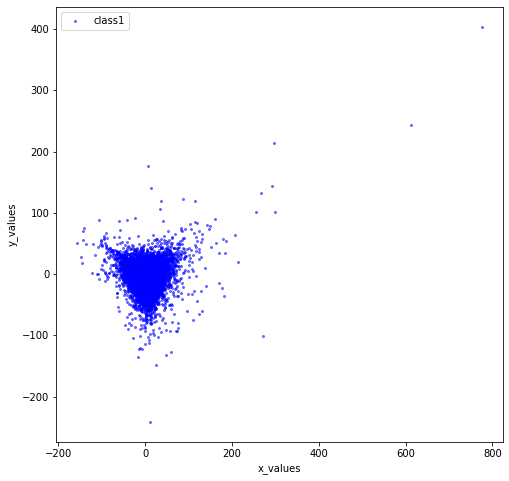

In [17]:

tocluster = pd.DataFrame(ps[[c1,c2]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[c1], tocluster[c2], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [18]:
# plot_pca(4, 1)

In [19]:
# plot_pca(0, 1)

In [20]:
# plot_pca(1,2)

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=cluster_count,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[  4.04672054 -17.49066036]
 [ -1.2796979    1.3284778 ]
 [ 36.25747132  10.24579474]]


In [22]:
print (c_preds[0:100])
print('c_preds.shape =', c_preds.shape)

[1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
c_preds.shape = (99876,)


['blue', 'purple', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']


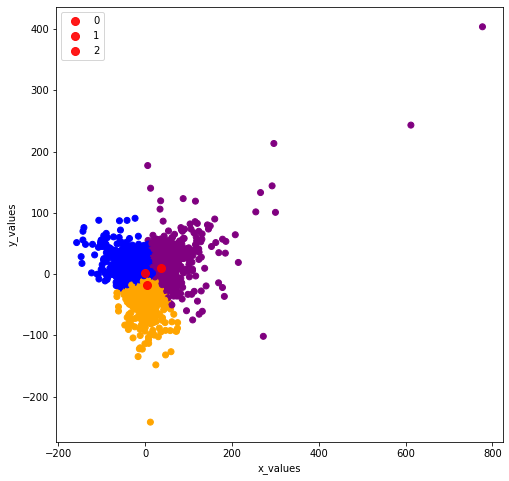

In [23]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[c1],tocluster[c2],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [24]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,2,0,31,2
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1


(99876, 135)


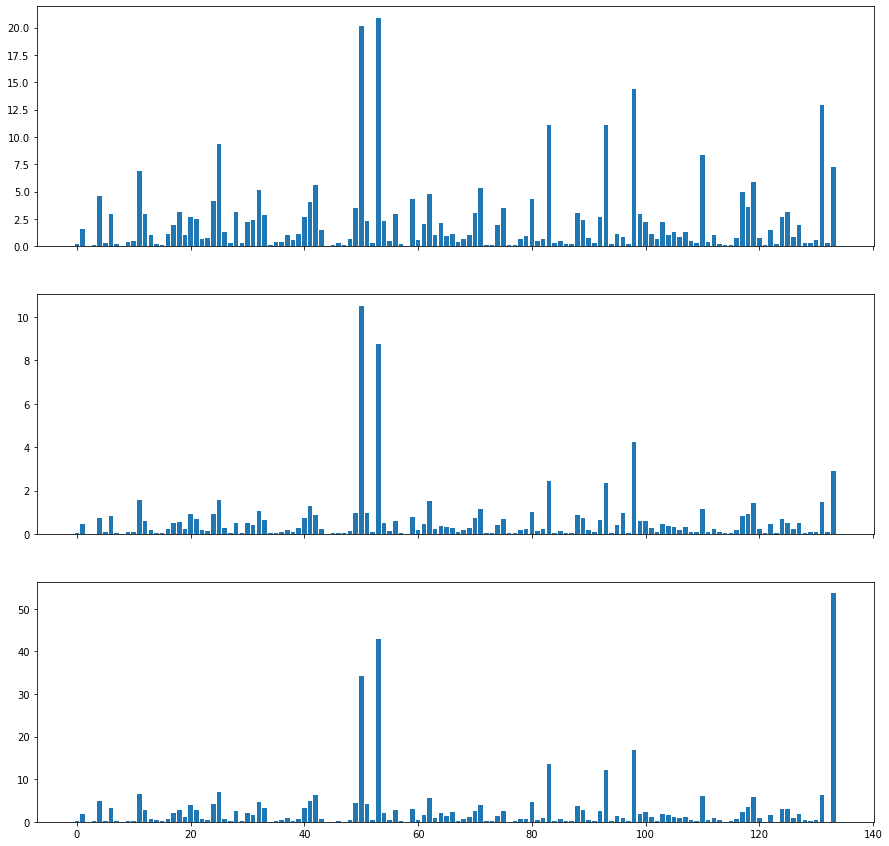

In [25]:
print (clust_prod.shape)
f,arr = plt.subplots(3,1,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)

c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)

c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[2].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)

# c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
# arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)

plt.show()

In [26]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 20.897115
fresh fruits                     20.156865
packaged vegetables fruits       14.344063
water seltzer sparkling water    12.875696
milk                             11.070447
packaged cheese                  11.059923
chips pretzels                    9.339359
refrigerated                      8.368206
yogurt                            7.246131
bread                             6.871239
dtype: float64

In [27]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     10.526640
fresh vegetables                  8.750410
packaged vegetables fruits        4.257407
yogurt                            2.889823
milk                              2.428579
packaged cheese                   2.372586
bread                             1.570002
chips pretzels                    1.546607
frozen produce                    1.516734
water seltzer sparkling water     1.472936
dtype: float64

In [28]:
c2.sort_values(ascending=False)[0:10]

aisle
yogurt                           53.628774
fresh vegetables                 43.016430
fresh fruits                     34.196714
packaged vegetables fruits       16.812611
milk                             13.527975
packaged cheese                  12.271314
chips pretzels                    6.897869
bread                             6.453819
energy granola bars               6.233126
water seltzer sparkling water     6.188277
dtype: float64

In [29]:
# c3.sort_values(ascending=False)[10:15]

In [30]:
clust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,2,0,31,2
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1


In [31]:
clust_prod = clust_prod.reset_index()
clust_prod.head()

aisle,user_id,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,3,0,0,0,0,1,0,0,...,1,1,0,0,0,0,2,0,31,2
2,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,1
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,5,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1


In [32]:
user_clusters = clust_prod[['user_id','cluster']]
user_clusters.head()

aisle,user_id,cluster
0,1,1
1,2,2
2,3,1
3,4,1
4,5,1


In [33]:
op = orders.merge(order_products_prior, on='order_id', how='inner')
print('op.shape', op.shape)
op.head()

op.shape (15806241, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


1. USER PREDICTORS




In [34]:
# Create distinct groups for each user, identify the highest order number in each group

# How many times has a user placed orders?

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
print('user.shape =', user.shape)
print('total users in the prior dataset =', user.shape[0])
user.head()

user.shape = (99999, 1)
total users in the prior dataset = 99999


,u_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [35]:
# Resetting index
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [36]:
# For a given user what is the mean of the reordered column?
# For a user, what is the ratio of reordered item to total items ordered?

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
print('u_reorder.shape', u_reorder.shape)
u_reorder.head()

u_reorder.shape (99999, 2)


,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [37]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

print('user.shape =', user.shape)
user.head()

user.shape = (99999, 3)


,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


2. PRODUCT PREDICTORS

In [38]:
# For each product, count the number of orders in which it was present
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
print('prd.shape =', prd.shape)
prd.head()

prd.shape = (49096, 2)


,product_id,p_total_purchases
0,-32768,258
1,-32767,2
2,-32766,9
3,-32765,241
4,-32764,56


In [39]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >260)
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (13952977, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [40]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (7936, 2)


,product_id,p_reorder_ratio
0,-32763,0.516447
1,-32755,0.530637
2,-32754,0.404517
3,-32752,0.473581
4,-32750,0.617100


In [41]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

print('prd.shape =', prd.shape)
prd.head()

prd.shape = (49096, 3)


,product_id,p_total_purchases,p_reorder_ratio
0,-32768,258,NaN
1,-32767,2,NaN
2,-32766,9,NaN
3,-32765,241,NaN
4,-32764,56,NaN


In [42]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,-32768,258,0.0
1,-32767,2,0.0
2,-32766,9,0.0
3,-32765,241,0.0
4,-32764,56,0.0


3. USER-PRODUCT PREDICTORS

In [43]:
# For a user, counting the number of products they bought of each type

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
1       -29585                     1
        -26608                     1
        -25879                     1
        -23749                     1
        -19387                     3

In [44]:
uxp = uxp.reset_index()
print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (6479328, 3)


,user_id,product_id,uxp_total_bought
0,1,-29585,1
1,1,-26608,1
2,1,-25879,1
3,1,-23749,1
4,1,-19387,3


In [45]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
print('times.shape =', times.shape)
times.head()

times.shape = (6479328, 1)


Times_Bought_N
user_id product_id                
1       -29585                   1
        -26608                   1
        -25879                   1
        -23749                   1
        -19387                   3

In [46]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders = total_orders.reset_index()
print('total_orders.shape =', total_orders.shape)
total_orders.head()

total_orders.shape = (99999, 2)


,user_id,total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [47]:
# Amongsnt all the orders a user placed, we are finding the order number where 
# a certain product was bought for the first time

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no = first_order_no.reset_index()
print('first_order_no.shape =', first_order_no.shape)
first_order_no.head()

first_order_no.shape = (6479328, 3)


,user_id,product_id,first_order_number
0,1,-29585,10
1,1,-26608,10
2,1,-25879,10
3,1,-23749,5
4,1,-19387,8


In [48]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
print('span.shape =', span.shape)
span.head()

span.shape = (6479328, 4)


,user_id,total_orders,product_id,first_order_number
0,1,10,-29585,10
1,1,10,-26608,10
2,1,10,-25879,10
3,1,10,-23749,5
4,1,10,-19387,8


In [49]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
print('span.shape =', span.shape)
span.head()

span.shape = (6479328, 5)


,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,-29585,10,1
1,1,10,-26608,10,1
2,1,10,-25879,10,1
3,1,10,-23749,5,6
4,1,10,-19387,8,3


In [50]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (6479328, 6)


,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,-29585,1,10,10,1
1,1,-26608,1,10,10,1
2,1,-25879,1,10,10,1
3,1,-23749,1,10,5,6
4,1,-19387,3,10,8,3


In [51]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,-29585,1,10,10,1,1.000000
1,1,-26608,1,10,10,1,1.000000
2,1,-25879,1,10,10,1,1.000000
3,1,-23749,1,10,5,6,0.166667
4,1,-19387,3,10,8,3,1.000000


In [52]:
# dropping all unrequired columns

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (6479328, 3)


,user_id,product_id,uxp_reorder_ratio
0,1,-29585,1.000000
1,1,-26608,1.000000
2,1,-25879,1.000000
3,1,-23749,0.166667
4,1,-19387,1.000000


In [53]:
#Remove temporary DataFrames
del [times, first_order_no, span]

In [54]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio

print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (6479328, 4)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,-29585,1,1.000000
1,1,-26608,1,1.000000
2,1,-25879,1,1.000000
3,1,-23749,1,0.166667
4,1,-19387,3,1.000000


MERGE ALL FEATURES

In [55]:
# Merging uxp features with the user features

data = uxp.merge(user, on='user_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (6479328, 6)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,1,-29585,1,1.000000,10,0.694915
1,1,-26608,1,1.000000,10,0.694915
2,1,-25879,1,1.000000,10,0.694915
3,1,-23749,1,0.166667,10,0.694915
4,1,-19387,3,1.000000,10,0.694915


In [56]:
# Merge uxp & user features (the new DataFrame) with prd features

data = data.merge(prd, on='product_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (6479328, 8)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,-29585,1,1.000000,10,0.694915,28610,0.758686
1,1,-26608,1,1.000000,10,0.694915,6256,0.821132
2,1,-25879,1,1.000000,10,0.694915,2424,0.768564
3,1,-23749,1,0.166667,10,0.694915,17115,0.649197
4,1,-19387,3,1.000000,10,0.694915,4188,0.815186


In [57]:
# del op, user, prd, uxp
del user, prd, uxp
gc.collect()

150

TRAIN DF

In [58]:
print('orders.shape =', orders.shape)
orders['eval_set'].unique()

orders.shape = (1665732, 7)


['prior', 'train', 'test']
Categories (3, object): ['prior', 'test', 'train']

In [59]:
print('op.shape =', op.shape)
op = op.drop(['eval_set', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order'], axis=1)
op.head(10)

op.shape = (15806241, 10)


,user_id,product_id,reordered
0,1,196,0
1,1,14084,0
2,1,12427,0
3,1,26088,0
4,1,26405,0
5,1,196,1
6,1,10258,0
7,1,12427,1
8,1,13176,0
9,1,26088,1


In [60]:
op = op.groupby(['user_id','product_id'])['reordered'].sum()

op = op.reset_index()
# op3 = op3[op3['new_reorder'] > 0]

# new_reorder = np.where(op3["new_reorder"] > 0, 1, 0)
op['reordered'] = op['reordered'].apply(lambda x: 0 if x == 0 else 1)
op.head(20)
op.shape

(6479328, 3)

In [61]:
opjoin = op.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin.shape =', opjoin.shape)

opjoin.shape = (6479328, 9)


In [62]:
del op

In [63]:
# opjoin.head(40)

In [64]:
opjoin['reordered'].unique()

array([0, 1])

In [65]:
opjoin = opjoin.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [66]:
opjoin = opjoin.merge(user_clusters, on='user_id', how='left')
opjoin.head()

,user_id,product_id,reordered,uxp_reorder_ratio,u_reordered_ratio,p_reorder_ratio,cluster
0,1,-29585,0,1.000000,0.694915,0.758686,1.0
1,1,-26608,0,1.000000,0.694915,0.821132,1.0
2,1,-25879,0,1.000000,0.694915,0.768564,1.0
3,1,-23749,0,0.166667,0.694915,0.649197,1.0
4,1,-19387,1,1.000000,0.694915,0.815186,1.0


In [67]:
opjoin = opjoin.set_index(['user_id', 'product_id'])
opjoin.head(11)

reordered  uxp_reorder_ratio  u_reordered_ratio  \
user_id product_id                                                    
1       -29585              0           1.000000           0.694915   
        -26608              0           1.000000           0.694915   
        -25879              0           1.000000           0.694915   
        -23749              0           0.166667           0.694915   
        -19387              1           1.000000           0.694915   
        -16301              1           0.666667           0.694915   
         196                1           1.000000           0.694915   
         10258              1           1.000000           0.694915   
         10326              0           0.166667           0.694915   
         12427              1           1.000000           0.694915   
         13032              1           0.333333           0.694915   

                    p_reorder_ratio  cluster  
user_id product_id                            
1       -29585             0.758686      1.0  
        -26608             0.821132      1.0  
        -25879             0.768564      1.0  
        -23749             0.649197      1.0  
        -19387             0.815186      1.0  
        -16301             0.776113      1.0  
         196               0.778384      1.0  
         10258             0.702890      1.0  
         10326             0.656945      1.0  
         12427             0.736740      1.0  
         13032             0.636527      1.0

In [68]:
opjoin.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6479328 entries, (1, -29585) to (99999, 32016)
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   reordered          int64  
 1   uxp_reorder_ratio  float64
 2   u_reordered_ratio  float64
 3   p_reorder_ratio    float64
 4   cluster            float64
dtypes: float64(4), int64(1)
memory usage: 300.8 MB


In [69]:
opjoin.head(20)

reordered  uxp_reorder_ratio  u_reordered_ratio  \
user_id product_id                                                    
1       -29585              0           1.000000           0.694915   
        -26608              0           1.000000           0.694915   
        -25879              0           1.000000           0.694915   
        -23749              0           0.166667           0.694915   
        -19387              1           1.000000           0.694915   
        -16301              1           0.666667           0.694915   
         196                1           1.000000           0.694915   
         10258              1           1.000000           0.694915   
         10326              0           0.166667           0.694915   
         12427              1           1.000000           0.694915   
         13032              1           0.333333           0.694915   
         13176              1           0.222222           0.694915   
         14084              0           0.100000           0.694915   
         17122              0           0.166667           0.694915   
         25133              1           1.000000           0.694915   
         26088              1           0.200000           0.694915   
         26405              1           0.200000           0.694915   
         30450              0           0.125000           0.694915   
2       -32744              1           0.642857           0.476923   
        -32260              1           0.181818           0.476923   

                    p_reorder_ratio  cluster  
user_id product_id                            
1       -29585             0.758686      1.0  
        -26608             0.821132      1.0  
        -25879             0.768564      1.0  
        -23749             0.649197      1.0  
        -19387             0.815186      1.0  
        -16301             0.776113      1.0  
         196               0.778384      1.0  
         10258             0.702890      1.0  
         10326             0.656945      1.0  
         12427             0.736740      1.0  
         13032             0.636527      1.0  
         13176             0.832709      1.0  
         14084             0.810235      1.0  
         17122             0.667543      1.0  
         25133             0.732268      1.0  
         26088             0.538889      1.0  
         26405             0.411765      1.0  
         30450             0.580547      1.0  
2       -32744             0.572901      2.0  
        -32260             0.000000      2.0

TEST DF 

In [70]:
order_products_train = order_products_train[order_products_train['reordered']==1]
print('order_products_train.shape =', order_products_train)
op_test = orders.merge(order_products_train, on='order_id', how='inner')
print('op_test.shape', op_test.shape)
op_test.head(20)

order_products_train.shape =         order_id  product_id  add_to_cart_order  reordered
1             36       19660                  2          1
3             36       43086                  4          1
4             36       46620                  5          1
5             36       34497                  6          1
6             36       48679                  7          1
...          ...         ...                ...        ...
672286   3420996       27423                  9          1
672287   3420996       12125                 10          1
672289   3421056        5750                  1          1
672290   3421056        9340                  2          1
672291   3421056       21709                  3          1

[403449 rows x 4 columns]
op_test.shape (403449, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1187899,1,train,11,4,8,14.0,196,1,1
1,1187899,1,train,11,4,8,14.0,25133,2,1
2,1187899,1,train,11,4,8,14.0,38928,3,1
3,1187899,1,train,11,4,8,14.0,26405,4,1
4,1187899,1,train,11,4,8,14.0,39657,5,1
5,1187899,1,train,11,4,8,14.0,10258,6,1
6,1187899,1,train,11,4,8,14.0,13032,7,1
7,1187899,1,train,11,4,8,14.0,26088,8,1
8,1187899,1,train,11,4,8,14.0,49235,10,1
9,1187899,1,train,11,4,8,14.0,46149,11,1


In [71]:
op_test = op_test.drop(['eval_set', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order'], axis=1)
op_test.head(15)

,user_id,product_id,reordered
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1
5,1,10258,1
6,1,13032,1
7,1,26088,1
8,1,49235,1
9,1,46149,1


In [72]:
op_test[op_test['user_id']==1]

,user_id,product_id,reordered
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1
5,1,10258,1
6,1,13032,1
7,1,26088,1
8,1,49235,1
9,1,46149,1


In [73]:
expected_y_df = op_test
expected_y_df = expected_y_df.rename(columns={"reordered": "expected_y"})
print('expected_y_df.shape =', expected_y_df.shape)
expected_y_df.head()

expected_y_df.shape = (403449, 3)


,user_id,product_id,expected_y
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1


In [74]:
opjoin_test = op_test.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin_test.shape =', opjoin_test.shape)

opjoin_test.shape = (403449, 9)


In [75]:
opjoin_test = opjoin_test.drop('reordered', axis=1)
opjoin_test.head(12)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10.0,1.000000,10.0,0.694915,17589.0,0.778384
1,1,25133,8.0,1.000000,10.0,0.694915,3003.0,0.732268
2,1,38928,NaN,NaN,NaN,NaN,NaN,NaN
3,1,26405,2.0,0.200000,10.0,0.694915,544.0,0.411765
4,1,39657,NaN,NaN,NaN,NaN,NaN,NaN
5,1,10258,9.0,1.000000,10.0,0.694915,865.0,0.702890
6,1,13032,3.0,0.333333,10.0,0.694915,1670.0,0.636527
7,1,26088,2.0,0.200000,10.0,0.694915,1260.0,0.538889
8,1,49235,NaN,NaN,NaN,NaN,NaN,NaN
9,1,46149,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
opjoin_test = opjoin_test.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [77]:
opjoin_test = opjoin_test.merge(user_clusters, on='user_id', how='left')
opjoin_test.head()

,user_id,product_id,uxp_reorder_ratio,u_reordered_ratio,p_reorder_ratio,cluster
0,1,196,1.0,0.694915,0.778384,1.0
1,1,25133,1.0,0.694915,0.732268,1.0
2,1,38928,NaN,NaN,NaN,1.0
3,1,26405,0.2,0.694915,0.411765,1.0
4,1,39657,NaN,NaN,NaN,1.0


In [78]:
opjoin_test = opjoin_test.set_index(['user_id', 'product_id'])
opjoin_test.head(20)

uxp_reorder_ratio  u_reordered_ratio  p_reorder_ratio  \
user_id product_id                                                          
1       196                  1.000000           0.694915         0.778384   
        25133                1.000000           0.694915         0.732268   
        38928                     NaN                NaN              NaN   
        26405                0.200000           0.694915         0.411765   
        39657                     NaN                NaN              NaN   
        10258                1.000000           0.694915         0.702890   
        13032                0.333333           0.694915         0.636527   
        26088                0.200000           0.694915         0.538889   
        49235                     NaN                NaN              NaN   
        46149                     NaN                NaN              NaN   
2       22963                0.285714           0.476923         0.661821   
        7963                 1.000000           0.476923         0.684015   
        16589                0.357143           0.476923         0.694419   
        32792                     NaN                NaN              NaN   
        41787                     NaN                NaN              NaN   
        22825                1.000000           0.476923         0.684143   
        24852                0.636364           0.476923         0.843754   
        45066                     NaN                NaN              NaN   
        5450                 0.166667           0.476923         0.670347   
        22559                0.166667           0.476923         0.559490   

                    cluster  
user_id product_id           
1       196             1.0  
        25133           1.0  
        38928           1.0  
        26405           1.0  
        39657           1.0  
        10258           1.0  
        13032           1.0  
        26088           1.0  
        49235           1.0  
        46149           1.0  
2       22963           2.0  
        7963            2.0  
        16589           2.0  
        32792           2.0  
        41787           2.0  
        22825           2.0  
        24852           2.0  
        45066           2.0  
        5450            2.0  
        22559           2.0

Build Model

In [79]:
import xgboost
from sklearn.model_selection import train_test_split
# data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)
# data_train.head()

In [80]:
opjoin.head()

reordered  uxp_reorder_ratio  u_reordered_ratio  \
user_id product_id                                                    
1       -29585              0           1.000000           0.694915   
        -26608              0           1.000000           0.694915   
        -25879              0           1.000000           0.694915   
        -23749              0           0.166667           0.694915   
        -19387              1           1.000000           0.694915   

                    p_reorder_ratio  cluster  
user_id product_id                            
1       -29585             0.758686      1.0  
        -26608             0.821132      1.0  
        -25879             0.768564      1.0  
        -23749             0.649197      1.0  
        -19387             0.815186      1.0

In [81]:
########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(opjoin.drop('reordered', axis=1), opjoin.reordered,
                                                    test_size=0.2, random_state=42)

[09:24:43] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-logloss:0.656952
[10]	train-logloss:0.510103
[20]	train-logloss:0.44733
[30]	train-logloss:0.407814
[40]	train-logloss:0.387993
[50]	train-logloss:0.376429
[60]	train-logloss:0.369881
[70]	train-logloss:0.360682
[79]	train-logloss:0.356207


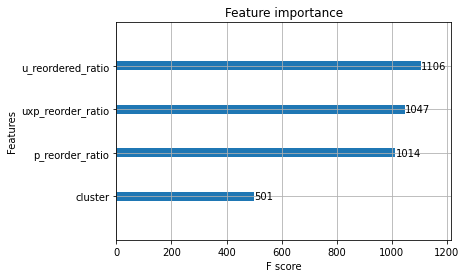

In [82]:
############################
## INITIATE AND TRAIN MODEL
############################

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [83]:
del [X_train, X_val, y_train, y_val]
gc.collect()

50

In [84]:
opjoin_test.head()

uxp_reorder_ratio  u_reordered_ratio  p_reorder_ratio  \
user_id product_id                                                          
1       196                       1.0           0.694915         0.778384   
        25133                     1.0           0.694915         0.732268   
        38928                     NaN                NaN              NaN   
        26405                     0.2           0.694915         0.411765   
        39657                     NaN                NaN              NaN   

                    cluster  
user_id product_id           
1       196             1.0  
        25133           1.0  
        38928           1.0  
        26405           1.0  
        39657           1.0

In [85]:
pred = xgboost.DMatrix(opjoin_test)

prediction = opjoin_test.reset_index()
prediction = prediction[['product_id', 'user_id']]

prediction["reordered_predicted"] = (bst.predict(pred) > 0.15).astype(int)
prediction

,product_id,user_id,reordered_predicted
0,196,1,1
1,25133,1,1
2,38928,1,1
3,26405,1,1
4,39657,1,1
...,...,...,...
403444,37646,99999,1
403445,14221,99999,1
403446,38383,99999,1
403447,6970,99999,1


In [86]:
tally = pd.merge(prediction, expected_y_df, on=['user_id', 'product_id'], how='inner')
tally.head()

,product_id,user_id,reordered_predicted,expected_y
0,196,1,1,1
1,25133,1,1,1
2,38928,1,1,1
3,26405,1,1,1
4,39657,1,1,1


In [87]:
tally.head(40)

,product_id,user_id,reordered_predicted,expected_y
0,196,1,1,1
1,25133,1,1,1
2,38928,1,1,1
3,26405,1,1,1
4,39657,1,1,1
5,10258,1,1,1
6,13032,1,1,1
7,26088,1,1,1
8,49235,1,1,1
9,46149,1,1,1


In [88]:
compare = np.where(tally["reordered_predicted"] == tally["expected_y"], True, False)

tally['compare'] = compare
tally.head()

,product_id,user_id,reordered_predicted,expected_y,compare
0,196,1,1,1,True
1,25133,1,1,1,True
2,38928,1,1,1,True
3,26405,1,1,1,True
4,39657,1,1,1,True


In [89]:
tally.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403449 entries, 0 to 403448
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   product_id           403449 non-null  int64
 1   user_id              403449 non-null  int64
 2   reordered_predicted  403449 non-null  int64
 3   expected_y           403449 non-null  int64
 4   compare              403449 non-null  bool 
dtypes: bool(1), int64(4)
memory usage: 15.8 MB


In [90]:
true_count = tally['compare'].sum()
true_count

377445

In [91]:
false_count = len(tally['compare'])
false_count

403449

In [92]:
accuracy = (true_count/(len(tally['compare'])))*100
print('Accuracy =', accuracy, '%')

Accuracy = 93.55457567127443 %


In [93]:
tally.head(40)

,product_id,user_id,reordered_predicted,expected_y,compare
0,196,1,1,1,True
1,25133,1,1,1,True
2,38928,1,1,1,True
3,26405,1,1,1,True
4,39657,1,1,1,True
5,10258,1,1,1,True
6,13032,1,1,1,True
7,26088,1,1,1,True
8,49235,1,1,1,True
9,46149,1,1,1,True


In [94]:
from sklearn import metrics

polo = metrics.confusion_matrix(tally['expected_y'], tally['reordered_predicted'])
print(polo)

[[     0      0]
 [ 26004 377445]]


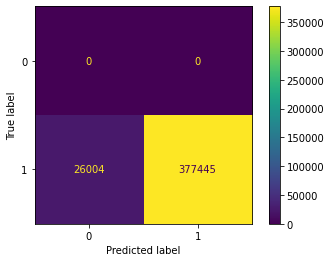

In [95]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=polo)
disp.plot()